In [69]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/tokyo_region_wind_speed_hourly.csv'

import pandas as pd
import numpy as np

data_org = pd.read_csv(file_path)
data_org = np.array(data_org)

#data reshaping

data_org = data_org[1:,1:]
data_org = np.array(data_org, dtype=float)

#standardization

mean_value = np.mean(data_org)
std_dev    = np.std(data_org)
data_org = (data_org - mean_value) / std_dev

# mean_value = np.mean(data, axis=0)
# std_dev = np.std(data, axis=0)
# data = (data - mean_value) / std_dev

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# @title Loading optuna
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

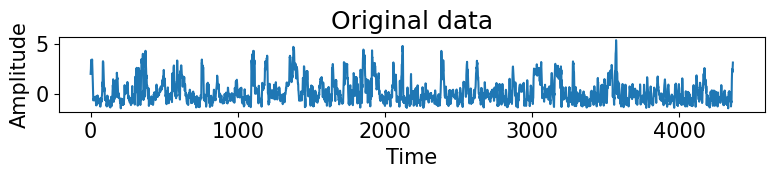

Data shape: (4367, 42)


In [71]:
# @title visualization of data

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data_org[:,9])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

print('Data shape:',data_org.shape)

Weight function of RealtimeFilter

$$\Psi(t)=
 \underbrace{\left(d_1\cos\left(\frac{t}{\pi r_1}\right)+d_2\cos\left(\frac{ t}{\pi r_2}\right)\right)}_{passing\ freq}
 \underbrace{\frac{(width+t)^c}{width^c}}_{band\ width}$$

In [72]:
# @title Definitions of RealtimeFilter and ``dictionary" for pattern extraction

################
#Filter code

def rb_filter(r_1, r_2, c,d_1,d_2, width, height):

    t_w = np.arange(-width, 0, 1)
    weight =  (d_1*np.cos(t_w/(np.pi*r_1))+d_2*np.cos(t_w/(np.pi*r_2)))* ((width+t_w)**c)/(width**c)
    weight = weight / height
    return weight

################
#Sigmoid function

def sigmoid(x,a,b):
    return 1 / (1 + np.exp(-a*(x-b)))

################
#correlation


def correlation(data1_in, data2_in, width,lg):
    n = len(data1_in)
    mean1 = np.mean(data1_in[width:n-width])
    mean2 = np.mean(data2_in[width:n-width])
    numerator = np.sum((data1_in[width:n - width- lg] - mean1) * (data2_in[width + lg:n-width] - mean2))
    denominator = np.sqrt(np.sum((data1_in[width:n-width-lg] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[width +lg: n-width] - mean2) ** 2))
    return numerator / denominator

########################################
###Dictionary for pattern extraction
########################################

import math
from collections import Counter, defaultdict

#Extract patterns and next values

def extract_patterns_and_next_values(discretized_data, max_dim,min_count, min_dim):

    patterns = []
    next_values = defaultdict(list)
    pattern_counts = Counter()


#Collect pair of pattern and next value

    for dim in range(max_dim, min_dim, -1):
        num_patterns = len(discretized_data) - dim

        for i in range(num_patterns):
            pattern = tuple(discretized_data[i:i+dim])  #Pattern
            next_value = discretized_data[i+dim]        #next value
            patterns.append(pattern)
            next_values[pattern].append(next_value)
            pattern_counts[pattern] += 1


# Delete fewer occurrences
    patterns = [pattern for pattern in patterns if pattern_counts[pattern] >= min_count]
    next_values = {pattern: values for pattern, values in next_values.items() if pattern_counts[pattern] >= min_count}

# Collect occurances of each patterns into frequency_array
    filtered_pattern_counts = {pattern: count for pattern, count in pattern_counts.items() if count >= min_count}
    frequency_array = np.array(list(filtered_pattern_counts.values()))



#In ``next_values", there already exist pairs of pattern and next value

    assigned_values, assigned_value_counts = assign_most_frequent_next_value_to_patterns(next_values)

    # calculate win_vote_rate
    win_vote_rate = {}
    for pattern in assigned_values:
        if pattern in pattern_counts:
            win_vote_rate[pattern] = float(assigned_value_counts[pattern]) / float(pattern_counts[pattern])


    return patterns, next_values, frequency_array, filtered_pattern_counts, win_vote_rate


################################
##Assign the most frequent next value to each patterns
################################

def assign_most_frequent_next_value_to_patterns(next_values):
    assigned_values = {}
    assigned_value_counts = {}

    for pattern, values in next_values.items():
        if values:
            counts = Counter(values)
            most_common_value = counts.most_common(1)[0][0]
            assigned_values[pattern] = most_common_value
            assigned_value_counts[pattern] = counts[most_common_value]
        else:
            print(f"Warning: No values found for pattern {pattern}, skipping assignment.")

    return assigned_values, assigned_value_counts

#####################################
##Fitting original data to disretized range
#####################################

def discretize_time_series(data, inverse_cdf_values):
    discretized_data = []
    for value in data:

        nearest_value = min(inverse_cdf_values, key=lambda x: abs(x - value))
        discretized_data.append(nearest_value)

    return discretized_data

In [73]:
# @title definition of pattern matching

def flt_train(data,data_flt,n_bins,T_train, max_dim,min_count, min_dim,min_win_vote_rate,width,min_cor):

    percentage_win_vote_rate = np.zeros(data.shape[1])
    filtered_pattern_counts = {}
    win_vote_rate = {}
    max_value = np.zeros(data.shape[1])

    for j in range(data.shape[1]):

# Calculate cumulative distribution function (CDF)
        cdf_values, bin_edges = np.histogram(data_flt[0:T_train,j].reshape(-1), bins='auto', density=True)
        cdf_values = np.cumsum(cdf_values)

# Generates equally spaced probability values
        probability_values = np.linspace(0, 1, n_bins + 1)

# Compute inverse CDF to obtain n_bins values
        inverse_cdf_values = np.interp(probability_values, cdf_values / cdf_values[-1], bin_edges[:-1])


        discretized_data= None
        pattens =None
        next_values = None
        assigned_values = None


# Fitting data to discrete values
        discretized_data = np.array(discretize_time_series(data_flt[0:T_train,j], inverse_cdf_values))

        patterns, next_values, frequency_array, filtered_pattern_counts[j], win_vote_rate[j] = \
        extract_patterns_and_next_values(discretized_data, max_dim,min_count, min_dim)

# Count patterns with win_vote_rate greater than or equal to ``min_win_vote_rate"
        count_win_vote_rate = sum(1 for rate in win_vote_rate[j].values() if rate >= min_win_vote_rate)

# Total number of pattern
        total_patterns = len(win_vote_rate[j])

# Percentage of patterns with win_vote_rate greater than or equal to ``min_win_vote_rate"
        if total_patterns == 0:
           percentage_win_vote_rate[j] = 0
        else:
           percentage_win_vote_rate[j] = count_win_vote_rate / total_patterns


################
#Require a minimum autocorrelation coefficient to the objective function
################

    max_lag = 0 #length of lag-correlation


    ac_data_flt = np.zeros((max_lag + 1))

# calculate lag-correlation

    for i in range(max_lag + 1):
          for j in range(data.shape[1]):
              ac_data_flt[i] = correlation(data[:T_train,j],data_flt[:,j], width, i)

######################
#OBJECTIVE FUNCTION!!!
######################
#we use the Sigmoid function to predetermine the minimum autocorrelation coefficient we want

          max_value[j] = (percentage_win_vote_rate[j] ** 1) *sigmoid(np.max(ac_data_flt[:]),20,min_cor)

    return max_value, percentage_win_vote_rate, filtered_pattern_counts, win_vote_rate, ac_data_flt

In [74]:
# @title Pre-train for original data

max_dim    = 4              #Max pattern length
min_dim    = 3              #Min pattern length (this number+1 is included)
min_count  = 4              #delete patterns if occurrence is fewer than this
n_bins     = 15             #number of partitions of range
min_win_vote_rate =0.7      #minimum requirement for win_vote_rate
min_cor    = 0.53            #requirement for minimum correlation to flted vs org
                            #(but real cor may become higher than this)

In [75]:
# @title Hyper parameters from Reservoir (determine train length of flt from these)

T_train      = 1000   # Training period
T_test       = 3      # Forecast period
initial_time = 0      # Starting time of training

max_lag    = 1
max_dim    = 4

In [76]:
# @title Data reshape

data = data_org[:initial_time+T_train+max_lag*max_dim+2*T_test,:]

print("data shape",data.shape)

data shape (1010, 42)


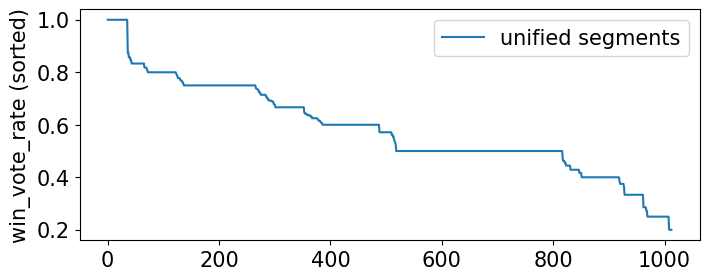

pattern matching rate: 0.29325573083112294 (win vote rate>= 0.7 )
Number of Patterns: 1013


In [77]:
# @title Visualization for the original data case

max_value, percentage_win_vote_rate, _, win_vote_rate, _ = \
flt_train(data,data,n_bins,initial_time+T_train+max_lag*max_dim+T_test, max_dim,min_count, min_dim,min_win_vote_rate,0,min_cor)

sorted_values = {}
all_values = []

for j in range(data.shape[1]):
    all_values.extend(win_vote_rate[j].values())

sorted_values = sorted(all_values, reverse=True)


# Visualization
fig, ax1 = plt.subplots(figsize=(8, 3))
x = range(len(sorted_values))
ax1.plot(x, sorted_values, label=f'unified segments')
ax1.set_ylabel('win_vote_rate (sorted)')
ax1.legend()
plt.show()

print('pattern matching rate:',np.mean(percentage_win_vote_rate),'(win vote rate>=',min_win_vote_rate,')')

element_counts = sum(len(values) for values in win_vote_rate.values())
print('Number of Patterns:',element_counts)

In [78]:
# @title Implementation of Bayesian optimization of RealtimeFilter

%%time

##########################
n_trials   = 200              #number of trials for optuna
##########################

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
import os

# Creating an Optuna Study
study = optuna.create_study(direction="maximize")

# Objective Function Definition
def objective(trial):
    r_1 = trial.suggest_float("r_1", 0.3, 3)#Especially on the high-frequency side, adjust while checking the SMOOTHING!
    r_2 = trial.suggest_float("r_2", 0.3, 3)#Especially on the high-frequency side, adjust while checking the SMOOTHING!
    c = trial.suggest_float("c", 0.2, 5)
    d_1 = trial.suggest_float("d_1", 0, 10)
    d_2 = trial.suggest_float("d_2", 0, 10)
    width = trial.suggest_int("width", 7, 30)

############
# Initializing

    data_flt = np.zeros((initial_time+T_train+max_lag*max_dim+T_test,data.shape[1]))

############
#Apply filter to multi-dimensional data_flt

    weight = rb_filter(r_1, r_2, c, d_1, d_2,width,1)

    for j in range(data.shape[1]):
        for i in range(width, T_train+max_lag*max_dim+T_test):
            data_flt[i,j] = np.dot(data[i-width+1:i+1,j],weight)

    max_value, percentage_win_vote_rate, filtered_pattern_counts, win_vote_rate, ac_data_flt = \
    flt_train(data,data_flt,n_bins,initial_time+T_train+max_lag*max_dim+T_test, max_dim,min_count, min_dim,min_win_vote_rate,width,min_cor)

    #total_max_value = np.min(max_value)
    total_max_value = np.max(max_value)

# We need this to extract best params
    trial.set_user_attr("data_flt", data_flt)
    trial.set_user_attr("percentage_win_vote_rate", percentage_win_vote_rate)
    trial.set_user_attr("filtered_pattern_counts", filtered_pattern_counts)
    trial.set_user_attr("win_vote_rate", win_vote_rate)
    trial.set_user_attr("ac_data_flt", ac_data_flt)

    return total_max_value


######################

# Implementation
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

data_flt                 = trial.user_attrs.get("data_flt")
percentage_win_vote_rate = trial.user_attrs.get("percentage_win_vote_rate")
filtered_pattern_counts  = trial.user_attrs.get("filtered_pattern_counts")
win_vote_rate            = trial.user_attrs.get("win_vote_rate")
ac_data_flt              = trial.user_attrs.get("ac_data_flt")

[I 2025-08-19 05:02:43,820] A new study created in memory with name: no-name-aa7e766f-9be8-4cce-9b65-67fde4ac4302
[I 2025-08-19 05:02:44,373] Trial 0 finished with value: 0.3748005939431652 and parameters: {'r_1': 1.1044478258827306, 'r_2': 1.7049735324087991, 'c': 4.118384466324265, 'd_1': 5.716590630854517, 'd_2': 5.077803254686367, 'width': 28}. Best is trial 0 with value: 0.3748005939431652.
[I 2025-08-19 05:02:44,930] Trial 1 finished with value: 0.3273971407309915 and parameters: {'r_1': 1.808341412290287, 'r_2': 1.962585179141192, 'c': 1.546452487046368, 'd_1': 0.587384157679729, 'd_2': 7.059152224223175, 'width': 22}. Best is trial 0 with value: 0.3748005939431652.
[I 2025-08-19 05:02:46,025] Trial 2 finished with value: 0.3499624551186478 and parameters: {'r_1': 0.898561820408188, 'r_2': 0.37586189612730225, 'c': 2.780321348268788, 'd_1': 7.547237818348645, 'd_2': 1.770561358622167, 'width': 7}. Best is trial 0 with value: 0.3748005939431652.
[I 2025-08-19 05:02:47,284] Trial 

Best trial:
  'params': {'r_1': 2.1750276889282034, 'r_2': 2.1506040835337332, 'c': 1.615698413023799, 'd_1': 6.096824398225699, 'd_2': 2.215061395400136, 'width': 19},
  'value': 0.49889587257139106,
CPU times: user 1min 19s, sys: 184 ms, total: 1min 19s
Wall time: 1min 23s


In [79]:
# @title Decisive filtering

best_params = study.best_params  # Get the best parameters

r_1          = best_params["r_1"]
r_2          = best_params["r_2"]
c            = best_params["c"]
d_1          = best_params["d_1"]
d_2          = best_params["d_2"]
width        = best_params["width"]


# Output and check
print(f"r_1 = {r_1}")
print(f"r_2 = {r_2}")
print(f"c = {c}")
print(f"d_1 = {d_1}")
print(f"d_2 = {d_2}")
print(f"width = {width}")

r_1 = 2.1750276889282034
r_2 = 2.1506040835337332
c = 1.615698413023799
d_1 = 6.096824398225699
d_2 = 2.215061395400136
width = 19


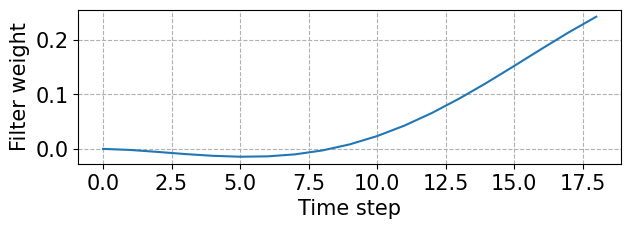

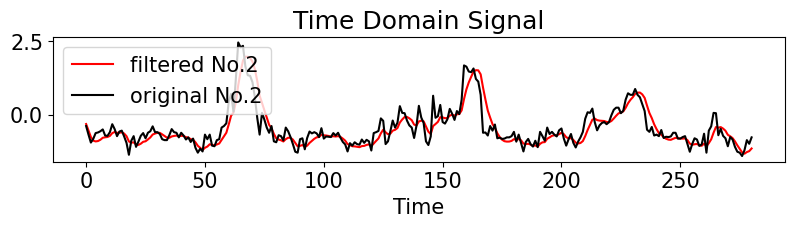

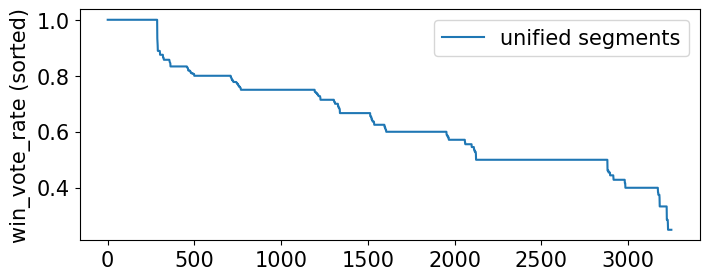

pattern matching rate: 0.4065558753829504 (win vote rate>= 0.7 )
Number of Patterns: 3251
maximum correlation coefficient: 0.8356671018058093
lag to achieve maximum value (out of max_lag): 0


In [80]:
# @title Reproduction of the deterministic RealtimeFilter

############
# Initializing

data_flt = np.zeros((data_org.shape[0],data_org.shape[1]))

############

weight = rb_filter(r_1, r_2, c, d_1, d_2,width,1)

for j in range(data_org.shape[1]):
    for i in range(width, data_org.shape[0]):
         data_flt[i,j] = np.dot(data_org[i-width+1:i+1,j],weight)


#####################
#Filter Standardization

std_dev_flt = np.std(data_flt)
data_flt = data_flt/std_dev_flt
filter = rb_filter(r_1, r_2, c,d_1,d_2, width, std_dev_flt)

######################
#Filter Visualization

fig = plt.figure(figsize=(7,2), dpi=100)
plt.grid(which='major', linestyle='--', axis='both')
plt.plot(filter[:])
plt.xlabel('Time step')
plt.ylabel('Filter weight')
plt.show()
plt.figure(figsize=(8, 4))


################
# Visualization

j = 2

plt.subplot(2, 1, 1)
plt.plot(data_flt[width:300,j], color = "red",label=f'filtered No.{j}')
plt.plot(data_org[width:300,j], color = "black",label=f'original No.{j}')
plt.title('Time Domain Signal')
plt.xlabel('Time')
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

sorted_values = {}

# unify segments
all_values = []
for j in range(data.shape[1]):
    all_values.extend(win_vote_rate[j].values())

sorted_values = sorted(all_values, reverse=True)


# Visualization
fig, ax1 = plt.subplots(figsize=(8, 3))
x = range(len(sorted_values))
ax1.plot(x, sorted_values, label=f'unified segments')
ax1.set_ylabel('win_vote_rate (sorted)')
ax1.legend()
plt.show()


print('pattern matching rate:',np.mean(percentage_win_vote_rate),'(win vote rate>=',min_win_vote_rate,')')

element_counts = sum(len(values) for values in win_vote_rate.values())
print('Number of Patterns:',element_counts)

max_value = np.max(ac_data_flt, axis = 0)
max_index = np.argmax(ac_data_flt,axis = 0)

print("maximum correlation coefficient:", max_value)
print("lag to achieve maximum value (out of max_lag):", max_index)


In [81]:
# @title Output filtered data

df = pd.DataFrame(data_flt[width:,:])#shift the filterd data
df.to_csv("flt_tokyo_region_wind_speed_hourly.csv", index=False,header=False, encoding="utf-8-sig")

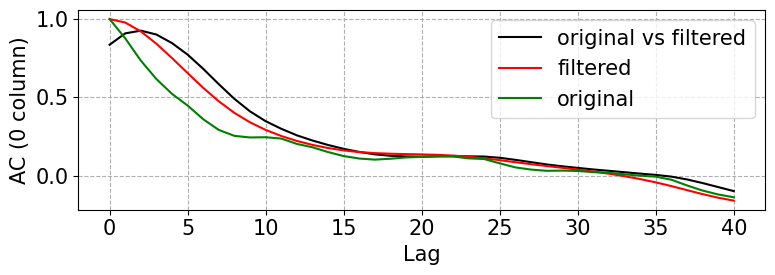

Correlation at NO lag: 0.8360979684676708
Max correlation: 0.9261336783295495
lag for max cor: 2


In [82]:
# @title Lag correlation

max_lag = 40

ac_data = []
ac_data_flt = []
ac_data_original = []

# Calculate autocorrelation: flt vs flt
for i in range(max_lag + 1):
    for j in range(data.shape[1]):
        ac = correlation(data_flt[:T_train,j], data_flt[:T_train,j], width, i)
    ac_data.append(ac)

#Calculate lag correlation: original vs flt
for i in range(max_lag + 1):
    for j in range(data.shape[1]):
        ac_flt = correlation(data[:T_train,j],data_flt[:T_train,j], width, i)
    ac_data_flt.append(ac_flt)

#Calculate autocorrelation: original vs original
for i in range(max_lag + 1):
    for j in range(data.shape[1]):
        ac_original = correlation(data[:T_train,j], data[:T_train,j], width, i)
    ac_data_original.append(ac_original)

#################
#Visualization


fig = plt.figure(figsize=(8,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("AC (0 column)")
plt.plot(ac_data_flt, color = "black",label="original vs filtered")
plt.plot(ac_data, color = "red",label="filtered")
plt.plot(ac_data_original, color = "green",label="original")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

max_value = np.max(ac_data_flt)
max_index = np.argmax(ac_data_flt)

print("Correlation at NO lag:", ac_data_flt[0])
print("Max correlation:", max_value)
print("lag for max cor:", max_index)